<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Utilities" data-toc-modified-id="Utilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Data-generation-and-processing" data-toc-modified-id="Data-generation-and-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data generation and processing</a></span></li><li><span><a href="#Variational-Autoencoder" data-toc-modified-id="Variational-Autoencoder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Variational Autoencoder</a></span><ul class="toc-item"><li><span><a href="#Latent-space-=-2-elements" data-toc-modified-id="Latent-space-=-2-elements-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Latent space = 2 elements</a></span><ul class="toc-item"><li><span><a href="#Define-models" data-toc-modified-id="Define-models-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Define models</a></span></li><li><span><a href="#Define-loss" data-toc-modified-id="Define-loss-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Define loss</a></span></li><li><span><a href="#Train-VAE" data-toc-modified-id="Train-VAE-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Train VAE</a></span></li><li><span><a href="#Display-the-results" data-toc-modified-id="Display-the-results-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Display the results</a></span></li><li><span><a href="#Interpolating-the-results" data-toc-modified-id="Interpolating-the-results-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Interpolating the results</a></span></li></ul></li><li><span><a href="#Latent-space-=-3-elements" data-toc-modified-id="Latent-space-=-3-elements-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Latent space = 3 elements</a></span><ul class="toc-item"><li><span><a href="#Define-models" data-toc-modified-id="Define-models-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Define models</a></span></li><li><span><a href="#Define-loss" data-toc-modified-id="Define-loss-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Define loss</a></span></li><li><span><a href="#Train-VAE" data-toc-modified-id="Train-VAE-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Train VAE</a></span></li><li><span><a href="#Display-the-results" data-toc-modified-id="Display-the-results-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Display the results</a></span></li><li><span><a href="#Interpolating-the-results" data-toc-modified-id="Interpolating-the-results-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Interpolating the results</a></span></li></ul></li></ul></li><li><span><a href="#GAN" data-toc-modified-id="GAN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>GAN</a></span><ul class="toc-item"><li><span><a href="#Creating-sampling-distributions" data-toc-modified-id="Creating-sampling-distributions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Creating sampling distributions</a></span></li><li><span><a href="#Discriminator-model" data-toc-modified-id="Discriminator-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Discriminator model</a></span></li><li><span><a href="#Generator-model" data-toc-modified-id="Generator-model-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Generator model</a></span></li><li><span><a href="#GAN-model" data-toc-modified-id="GAN-model-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>GAN model</a></span></li><li><span><a href="#Train-GAN" data-toc-modified-id="Train-GAN-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Train GAN</a></span></li><li><span><a href="#Interpolating-the-results" data-toc-modified-id="Interpolating-the-results-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Interpolating the results</a></span></li></ul></li></ul></div>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Concatenate, LeakyReLU, Flatten, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras import backend as K

import statistics
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import FloatSlider, interact
import os
import skimage
from operator import itemgetter

Using TensorFlow backend.


In [2]:
%matplotlib notebook

## Utilities

In [3]:
# MASKS
mask_plus = np.array([[False, False, True, False, False],
                      [False, False, True, False, False],
                      [True, True, True, True, True],
                      [False, False, True, False, False],
                      [False, False, True, False, False]])

mask_cross = np.array([[True, False, False, False, True],
                       [False, True, False, True, False],
                       [False, False, True, False, False],
                       [False, True, False, True, False],
                       [True, False, False, False, True]])

mask_square = np.array([[False, False, False, False, False],
                        [False, True, True, True, False],
                        [False, True, False, True, False],
                        [False, True, True, True, False],
                        [False, False, False, False, False]])

masks_one_hot = {'plus': [1, 0, 0],
                 'cross': [0, 1, 0],
                 'square': [0, 0, 1]}

masks_masking = {'plus': mask_plus,
                 'cross': mask_cross,
                 'square': mask_square}


def generate_image(mask, noise=False, noise_var=0.03):
    img = np.ones((5, 5)).astype('float32')
    img[masks_masking[mask]] = 0

    if noise:
        img = skimage.util.random_noise(img, mode='gaussian', clip='True', var=noise_var)

    return img


def get_data(samples_number=1000, noise=True, noise_var=0.03):
    mask = np.random.choice(list(masks_one_hot.keys()), size=samples_number)
    images = np.empty((samples_number, 5, 5))
    for idx, slice in enumerate(images):
        images[idx] = generate_image(mask[idx], noise, noise_var)

    labels = itemgetter(*mask)(masks_one_hot)

    return mask, images, labels

<IPython.core.display.Javascript object>


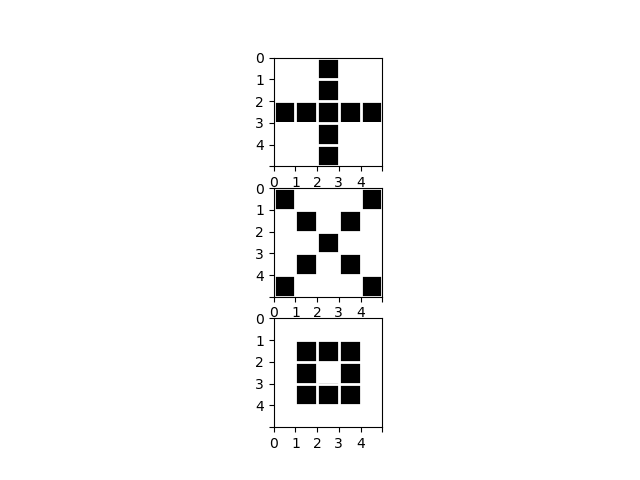

In [4]:
# GENERATE IMAGES
plt.figure()

plt.subplot(311)
plt.imshow(generate_image('plus'), cmap='gray')
plt.xticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.yticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.grid(which='major', color='w', linestyle='-', linewidth=2)

plt.subplot(312)
plt.imshow(generate_image('cross'), cmap='gray')
plt.xticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.yticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.grid(which='major', color='w', linestyle='-', linewidth=2)

plt.subplot(313)
plt.imshow(generate_image('square'), cmap='gray')
plt.xticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.yticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.grid(which='major', color='w', linestyle='-', linewidth=2)

plt.show()

<IPython.core.display.Javascript object>


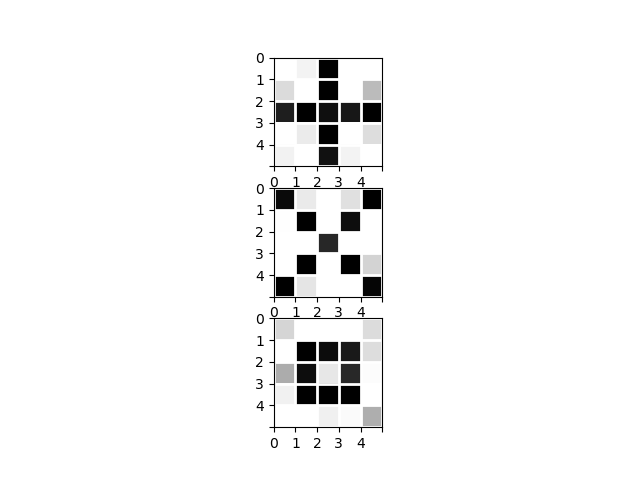

In [5]:
# GENERATE IMAGES WITH NOISE
plt.figure()

plt.subplot(311)
plt.imshow(generate_image('plus', True), cmap='gray')
plt.xticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.yticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.grid(which='major', color='w', linestyle='-', linewidth=2)

plt.subplot(312)
plt.imshow(generate_image('cross', True), cmap='gray')
plt.xticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.yticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.grid(which='major', color='w', linestyle='-', linewidth=2)

plt.subplot(313)
plt.imshow(generate_image('square', True), cmap='gray')
plt.xticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.yticks(np.arange(-.5, 5, 1), labels=np.arange(0, 5, 1))
plt.grid(which='major', color='w', linestyle='-', linewidth=2)

plt.show()

<IPython.core.display.Javascript object>


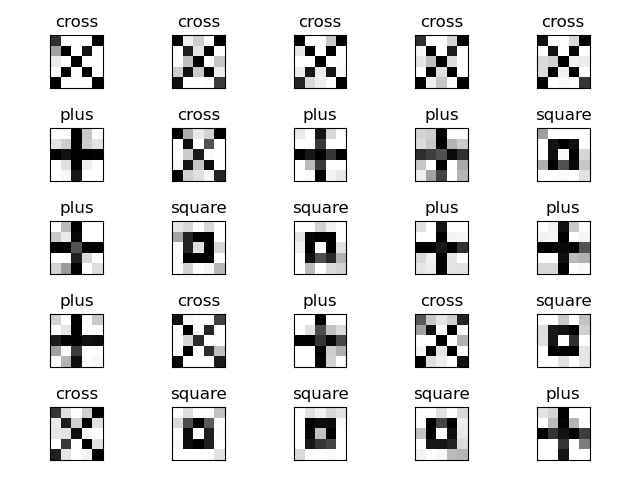

In [6]:
# GET SAMPLE IMAGES AND LABELS
mask_name, data, labels = get_data()

plt.figure()
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, 5 * i + j + 1)
        plt.imshow(data[5 * i + j], cmap='gray')
        plt.title(mask_name[5 * i + j])
        plt.xticks([])
        plt.yticks([])

plt.tight_layout()
plt.show()

## Data generation and processing

In [7]:
mask_name, data, labels = get_data(samples_number=50000, noise=True)
labels = np.argmax(labels, axis=1)  # cast to ints
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())

In [8]:
# Model basic parameters
input_shape = (original_dim,)
intermediate_dim = 256
batch_size = 512
epochs = 15

## Variational Autoencoder

In [9]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Latent space = 2 elements

#### Define models

In [10]:
latent_dim = 2

In [11]:
# VAE model = encoder + decoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
get_statistics = Model(inputs=[inputs], outputs=[z_mean, z_log_var])

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          6656        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

#### Define loss

In [12]:
# a reconstruction loss forcing the decoded samples to match the initial inputs 
# + KL divergence between the learned latent distribution and the prior distribution
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 25)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 7684      
_________________________________________________________________
decoder (Model)              (None, 25)                7193      
Total params: 14,877
Trainable params: 14,877
Non-trainable params: 0
_________________________________________________________________


c:\users\virnael\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


#### Train VAE

In [13]:
#vae.load_weights("E:\\Drive\\Politechnika\\3II\\GSN_II\\Projekt\\vae_mlp_mnist.h5")
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 1s 24us/step - loss: 13.9046 - val_loss: 10.0776
Epoch 2/15
40000/40000 [==============================] - 0s 12us/step - loss: 8.8701 - val_loss: 8.4859
Epoch 3/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.4683 - val_loss: 8.4722
Epoch 4/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.4288 - val_loss: 8.4472
Epoch 5/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.4132 - val_loss: 8.3790
Epoch 6/15
40000/40000 [==============================] - 0s 12us/step - loss: 8.3889 - val_loss: 8.3759
Epoch 7/15
40000/40000 [==============================] - 0s 12us/step - loss: 8.3589 - val_loss: 8.3420
Epoch 8/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.3314 - val_loss: 8.3266
Epoch 9/15
40000/40000 [==============================] - 0s 12us/step - loss: 8.3023 - val_loss: 8.2947
Epo

#### Display the results

In [14]:
# Predicted data
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)

In [15]:
def calculate_statistics(data, label, category, name, c):
    # Point precise point for perfect shapes
    data_perfect = get_statistics.predict(np.reshape(generate_image(name), [-1, original_dim]))
    print("Perfect {} is described with mean vector = {} and log variance = {}".format(
        name, np.round(data_perfect[0][0], 2), np.round(data_perfect[1][0], 2)))
    plt.scatter(data_perfect[0][0][0], data_perfect[0][0][1], marker='x', s=100, label=['Perfect cross'], color=c)
    
    # Point for entire dataset
    data = data[y_test == category].astype(float)
    data = [np.round(np.mean(data[:, 0]), 2), np.round(np.mean(data[:, 1]), 2)], [np.round(statistics.stdev(data[:, 0]), 2), np.round(statistics.stdev(data[:, 1]), 2)]
    print("Entire {} dataset is described with mean vector = {} and standard deviation = {}\n".format(
        name, data[0], data[1]))
    
    plt.scatter(data[0][0], data[0][1], marker='x', s=100, label=['{} dataset mean sample'.format(name)], color=c)


<IPython.core.display.Javascript object>


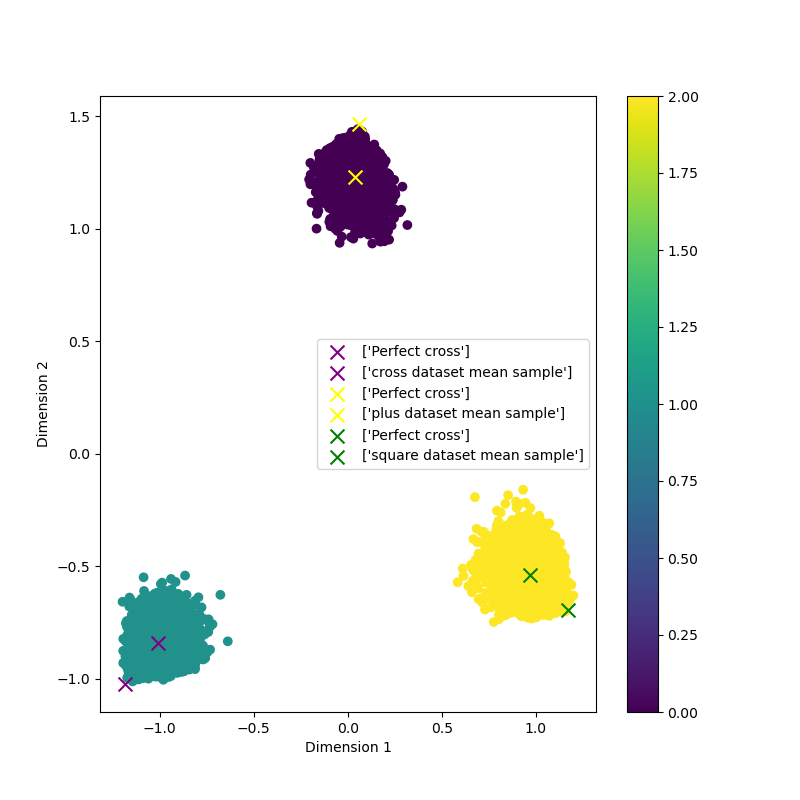

Perfect cross is described with mean vector = [-1.18 -1.02] and log variance = [-1.72 -1.38]
Entire cross dataset is described with mean vector = [-1.01, -0.84] and standard deviation = [0.08, 0.08]

Perfect plus is described with mean vector = [0.06 1.47] and log variance = [-0.12 -2.48]
Entire plus dataset is described with mean vector = [0.04, 1.23] and standard deviation = [0.08, 0.09]

Perfect square is described with mean vector = [ 1.17 -0.69] and log variance = [-1.7  -1.35]
Entire square dataset is described with mean vector = [0.97, -0.54] and standard deviation = [0.09, 0.09]



In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

calculate_statistics(z_mean, y_test, 1, 'cross', 'purple')
calculate_statistics(z_mean, y_test, 0, 'plus', 'yellow')
calculate_statistics(z_mean, y_test, 2, 'square', 'green')

plt.legend()
plt.show()

#### Interpolating the results

<IPython.core.display.Javascript object>


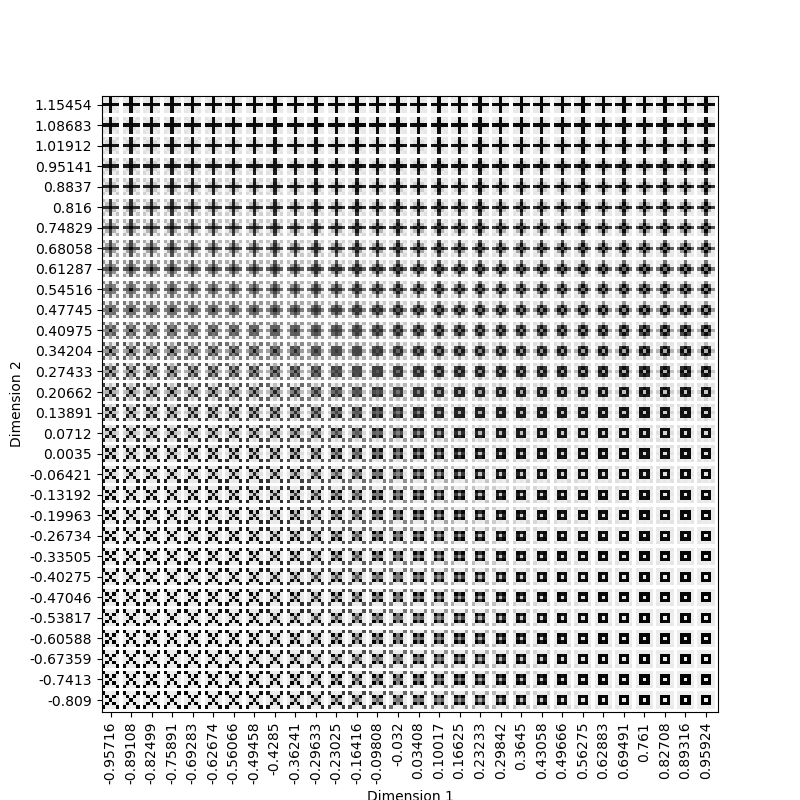

In [17]:
# display a 30 x 30 signs
n = 30
sign_size = int(np.sqrt(x_test[0].shape[0]))  # square
figure = np.ones((sign_size * n + n, sign_size * n + n))
grid_x = np.linspace(0.8 * np.min(z_mean[:, 0]), 0.8 * np.max(z_mean[:, 0]), n)
grid_y = np.linspace(0.8 * np.min(z_mean[:, 1]), 0.8 * np.max(z_mean[:, 1]), n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        sign = x_decoded[0].reshape(sign_size, sign_size)
        figure[i * sign_size + i % len(grid_y): (i + 1) * sign_size + i % len(grid_y),
        j * sign_size + j % len(grid_x): (j + 1) * sign_size + j % len(grid_x)] = sign

plt.figure(figsize=(8, 8))
start_range = sign_size // 2
end_range = (n - 1) * sign_size + start_range + 1 + n
pixel_range = np.arange(start_range, end_range, sign_size + 1)
sample_range_x = np.round(grid_x, 5)
sample_range_y = np.round(grid_y, 5)
plt.xticks(pixel_range, sample_range_x, rotation='vertical')
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.imshow(figure, cmap='gray')
plt.show()

### Latent space = 3 elements

#### Define models

In [18]:
latent_dim = 3

In [19]:
# VAE model = encoder + decoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
get_statistics = Model(inputs=[inputs], outputs=[z_mean, z_log_var])

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          6656        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            771         dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            771         dense_4[0][0]                    
____________________________________________________________________________________________

#### Define loss

Loss is calculated in the same way as previously.

In [20]:
# a reconstruction loss forcing the decoded samples to match the initial inputs 
# + KL divergence between the learned latent distribution and the prior distribution
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 25)                0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 8198      
_________________________________________________________________
decoder (Model)              (None, 25)                7449      
Total params: 15,647
Trainable params: 15,647
Non-trainable params: 0
_________________________________________________________________


c:\users\virnael\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


#### Train VAE

In [21]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
# vae.save_weights('vae_mlp_mnist.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 1s 17us/step - loss: 13.6724 - val_loss: 10.1264
Epoch 2/15
40000/40000 [==============================] - 0s 12us/step - loss: 9.0295 - val_loss: 8.6403
Epoch 3/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.5288 - val_loss: 8.4775
Epoch 4/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.4363 - val_loss: 8.4404
Epoch 5/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.4158 - val_loss: 8.3852
Epoch 6/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.3832 - val_loss: 8.3812
Epoch 7/15
40000/40000 [==============================] - 0s 12us/step - loss: 8.3589 - val_loss: 8.3680
Epoch 8/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.3407 - val_loss: 8.3409
Epoch 9/15
40000/40000 [==============================] - 0s 11us/step - loss: 8.3261 - val_loss: 8.3151
Epo

#### Display the results

In [22]:
z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)

In [23]:
def calculate_statistics_3D(data, label, category, name, c, ax):
    # Point precise point for perfect shapes
    data_perfect = get_statistics.predict(np.reshape(generate_image(name), [-1, original_dim]))
    print("Perfect {} is described with mean vector = {} and log variance = {}".format(
        name, np.round(data_perfect[0][0], 2), np.round(data_perfect[1][0], 2)))
    ax.scatter(data_perfect[0][0][0], data_perfect[0][0][1], data_perfect[0][0][2], marker='x', s=100, label=['Perfect cross'], color=c)
    
    # Point for entire dataset
    data = data[y_test == category].astype(float)
    data = [np.round(np.mean(data[:, 0]), 2), np.round(np.mean(data[:, 1]), 2), np.round(np.mean(data[:, 2]), 2)], [np.round(statistics.stdev(data[:, 0]), 2), np.round(statistics.stdev(data[:, 1]), 2), np.round(statistics.stdev(data[:, 2]), 2)]
    print("Entire {} dataset is described with mean vector = {} and standard deviation = {}\n".format(
        name, data[0], data[1]))
    
    ax.scatter(data[0][0], data[0][1], data[0][2], marker='x', s=100, label=['{} dataset mean sample'.format(name)], color=c)

<IPython.core.display.Javascript object>


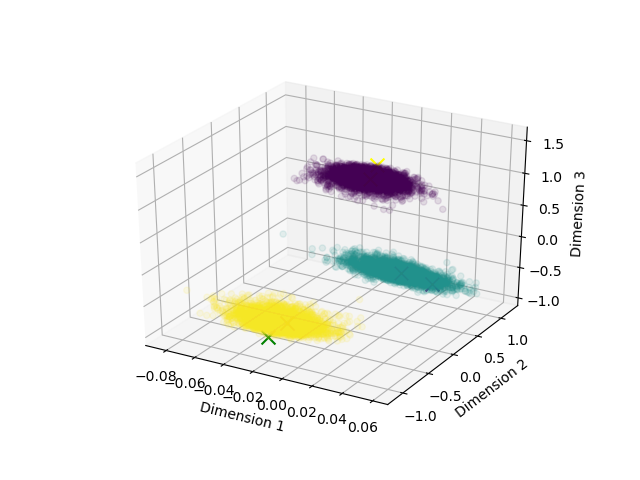

Perfect cross is described with mean vector = [ 0.02  1.18 -0.95] and log variance = [ 0.   -1.67 -1.46]
Entire cross dataset is described with mean vector = [-0.0, 1.01, -0.75] and standard deviation = [0.02, 0.08, 0.08]

Perfect plus is described with mean vector = [0.02 0.04 1.52] and log variance = [ 0.   -0.03 -2.55]
Entire plus dataset is described with mean vector = [0.01, 0.07, 1.28] and standard deviation = [0.01, 0.08, 0.08]

Perfect square is described with mean vector = [-0.02 -1.1  -0.66] and log variance = [-0.   -1.61 -1.36]
Entire square dataset is described with mean vector = [-0.01, -0.92, -0.51] and standard deviation = [0.01, 0.08, 0.09]



In [24]:
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2], c=y_test, alpha=0.1)
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

calculate_statistics_3D(z_mean, y_test, 1, 'cross', 'purple', ax)
calculate_statistics_3D(z_mean, y_test, 0, 'plus', 'yellow', ax)
calculate_statistics_3D(z_mean, y_test, 2, 'square', 'green', ax)

plt.show()

<IPython.core.display.Javascript object>


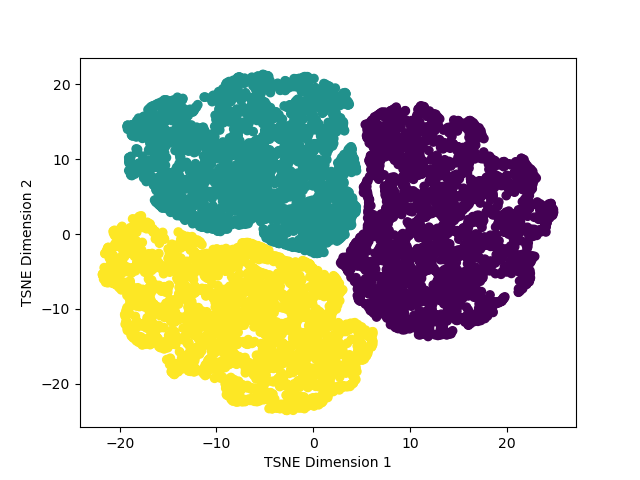

In [25]:
# TSNE
tsne = TSNE(n_components=2, verbose=0, min_grad_norm=1e-3)
X_embedded = tsne.fit_transform(z_mean)
plt.figure()
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_test)
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.show()

#### Interpolating the results

<IPython.core.display.Javascript object>


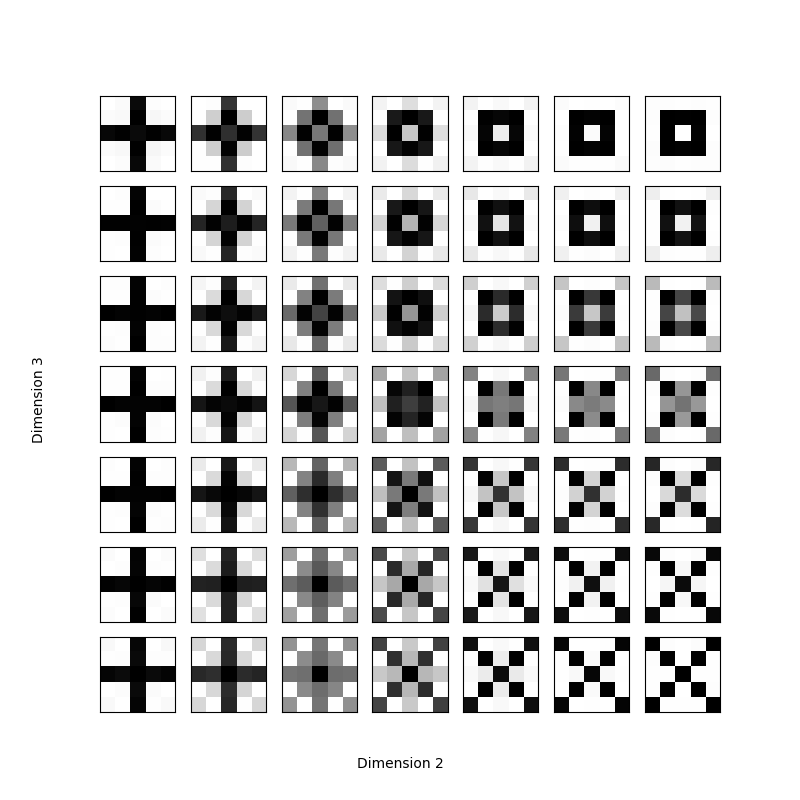

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Dimension 1', max=0.0474489…

In [26]:
fig, axs = plt.subplots(nrows=7, ncols = 7, figsize=(8, 8))
fig.text(0.5, 0.04, 'Dimension 2', ha='center')
fig.text(0.04, 0.5, 'Dimension 3', va='center', rotation='vertical')

grid_x = np.linspace(0.8 * np.min(z_mean[:, 1]), 0.8 * np.max(z_mean[:, 1]), 7)
grid_y = np.linspace(0.8 * np.min(z_mean[:, 2]), 0.8 * np.max(z_mean[:, 2]), 7)[::-1]

def update(dimension1 = 0.0):
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            ax = axs[j][i]
            z_sample = np.array([[dimension1, xi, yi]])
            x_decoded = decoder.predict(z_sample)
            sign = x_decoded[0].reshape(sign_size, sign_size)
            ax.imshow(sign, cmap='gray')
            ax.set_xticks([], [])
            ax.set_yticks([], [])


interact(update, dimension1 = FloatSlider(value=0.0,
                                        min=0.8 * np.min(z_mean[:, 0]),
                                        max=0.8 * np.max(z_mean[:, 0]),
                                        step=(0.8 * np.max(z_mean[:, 0]) - 0.8 * np.min(z_mean[:, 0]))/10, 
                                        description='Dimension 1',
                                        continuous_update=False))

plt.show()

## GAN

### Creating sampling distributions

In [27]:
distribution_parameters = [[(1, 0.1), (0.4, 0.1), (0.4, 0.1)],
                           [(-1, 0.1), (-0.4, 0.1), (0.4, 0.1)],
                           [(0, 0.1), (0, 0.1), (-1, 0.1)]]

_, data, labels = get_data(samples_number=50000, noise=True, noise_var=0.01)
labels = np.argmax(labels, axis=1)
x_train = data.astype('float32')
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_train = np.expand_dims(x_train, axis=-1)
z = np.array([[np.random.normal(loc=p[0], scale=p[1]) for p in distribution_parameters[label]] for label in labels])

<IPython.core.display.Javascript object>


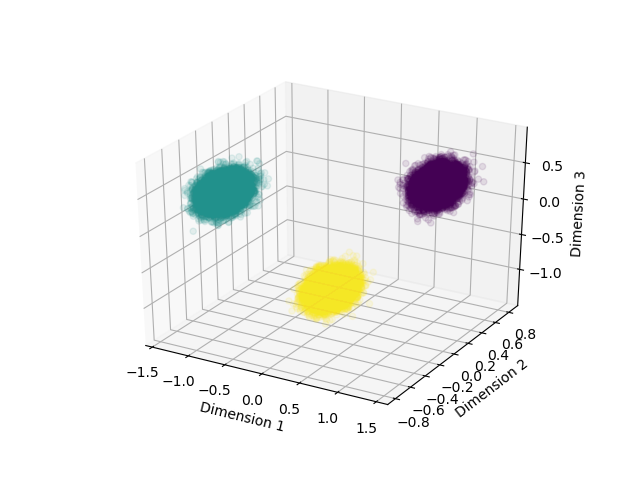

In [28]:
#3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=labels, alpha=0.1)
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

plt.show()

### Discriminator model

In [29]:
def define_discriminator(input_shape=(5,5,1), latent_dim_shape=(3,), fc1_size=32, fc2_size=32):
    inputs = Input(shape=input_shape, name='d_img_input')
    inputs_flat = Flatten(name='d_img_input_flat')(inputs)
    latent_inputs = Input(shape=latent_dim_shape, name='d_sampling_input')
    merge = Concatenate(name='d_merge_inputs')([inputs_flat, latent_inputs])
    x = Dense(fc1_size, name='d_fc1')(merge)
    x = LeakyReLU(alpha=0.2, name='d_fc1_activation')(x)
    x = Dense(fc2_size, name='d_fc2')(x)
    x = LeakyReLU(alpha=0.2, name='d_fc2_activation')(x)
    out = Dense(1, activation='sigmoid', name='d_output')(x)
    discriminator = Model(inputs=[inputs, latent_inputs], outputs=[out], name='discriminator')
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.summary()
    return discriminator

d_model = define_discriminator()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_img_input (InputLayer)        (None, 5, 5, 1)      0                                            
__________________________________________________________________________________________________
d_img_input_flat (Flatten)      (None, 25)           0           d_img_input[0][0]                
__________________________________________________________________________________________________
d_sampling_input (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
d_merge_inputs (Concatenate)    (None, 28)           0           d_img_input_flat[0][0]           
                                                                 d_sampling_input[0][0

### Generator model

In [30]:
def define_generator(input_shape=(5,5,1), latent_dim_shape=(3,), fc1_size=16, fc2_size=25):
    latent_inputs = Input(shape=latent_dim_shape, name='g_sampling_input')
    x = Dense(fc1_size, name='g_fc1')(latent_inputs)
    x = LeakyReLU(alpha=0.2, name='g_fc1_activation')(x)
    x = Dense(fc2_size, name='g_fc2')(x)
    x = LeakyReLU(alpha=0.2, name='g_fc2_activation')(x)
    x_reshaped = Reshape(input_shape, name='g_output')(x)
    generator = Model(latent_inputs, x_reshaped, name='generator')
    generator.summary()
    return generator

g_model = define_generator()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_sampling_input (InputLayer (None, 3)                 0         
_________________________________________________________________
g_fc1 (Dense)                (None, 16)                64        
_________________________________________________________________
g_fc1_activation (LeakyReLU) (None, 16)                0         
_________________________________________________________________
g_fc2 (Dense)                (None, 25)                425       
_________________________________________________________________
g_fc2_activation (LeakyReLU) (None, 25)                0         
_________________________________________________________________
g_output (Reshape)           (None, 5, 5, 1)           0         
Total params: 489
Trainable params: 489
Non-trainable params: 0
___________________________________________________________

### GAN model

In [31]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get latent inputs from generator model
    latent_input = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and latent input from generator as inputs to discriminator
    gan_output = d_model([gen_output, latent_input])
    # define gan model
    gan = Model(latent_input, gan_output, name='gan')
    # compile model
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    gan.summary()
    return gan

gan_model = define_gan(g_model, d_model)

Model: "gan"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_sampling_input (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
g_fc1 (Dense)                   (None, 16)           64          g_sampling_input[0][0]           
__________________________________________________________________________________________________
g_fc1_activation (LeakyReLU)    (None, 16)           0           g_fc1[0][0]                      
__________________________________________________________________________________________________
g_fc2 (Dense)                   (None, 25)           425         g_fc1_activation[0][0]           
________________________________________________________________________________________________

### Train GAN

In [32]:
def show_plot(examples, n):
    plt.figure()
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray')
    plt.show()


def get_real_samples(n_samples):
    ix = np.random.randint(0, x_train.shape[0], n_samples)
    X, l = x_train[ix], z[ix]
    y = np.ones((n_samples, 1))
    return [X, l], y


def choose_random_latent_points(n_samples):
    ix = np.random.randint(0, z.shape[0], n_samples)
    return z[ix]


def get_fake_samples(generator, n_samples):
    l = choose_random_latent_points(n_samples)
    X = generator.predict(l)
    y = np.zeros((n_samples, 1))
    return [X, l], y


def train(g_model, d_model, gan_model, n_epochs=100, batch_size=512):
    batches_per_epoch = int(x_train.shape[0] / batch_size)
    half_batch_size = int(batch_size / 2)
    for epoch in range(n_epochs):
        for batch in range(batches_per_epoch):
            [X_real, l_real], y_real = get_real_samples(half_batch_size)
            d_loss1, _ = d_model.train_on_batch([X_real, l_real], y_real)
            [X_fake, l_fake], y_fake = get_fake_samples(g_model, half_batch_size)
            d_loss2, _ = d_model.train_on_batch([X_fake, l_fake], y_fake)
            l = choose_random_latent_points(batch_size)
            y_gan = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(l, y_gan)
            
        print(f'Epoch: {epoch+1}, d1={d_loss1:.3f}, d2={d_loss2:.3f}, g={g_loss:.3f}')
        
        if (epoch+1) % 10 == 0:
            show_plot(g_model.predict(choose_random_latent_points(25)), 5)
            
#     g_model.save('generator.h5')

c:\users\virnael\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1, d1=0.075, d2=0.269, g=1.522
Epoch: 2, d1=0.131, d2=0.163, g=2.179
Epoch: 3, d1=0.341, d2=0.211, g=1.911
Epoch: 4, d1=0.547, d2=0.454, g=1.550
Epoch: 5, d1=0.353, d2=0.266, g=1.805
Epoch: 6, d1=0.490, d2=0.316, g=1.510
Epoch: 7, d1=0.581, d2=0.509, g=1.038
Epoch: 8, d1=0.297, d2=0.304, g=1.423
Epoch: 9, d1=0.523, d2=0.633, g=0.901
Epoch: 10, d1=0.410, d2=0.584, g=1.025


<IPython.core.display.Javascript object>


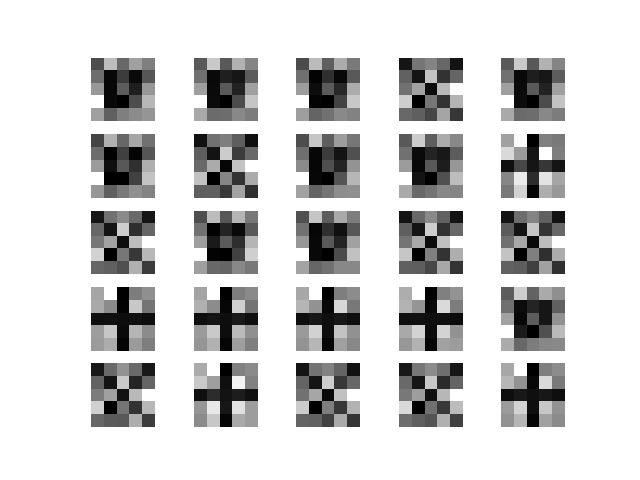

Epoch: 11, d1=0.671, d2=0.798, g=0.762
Epoch: 12, d1=0.776, d2=0.591, g=0.952
Epoch: 13, d1=0.824, d2=0.633, g=0.983
Epoch: 14, d1=0.632, d2=0.614, g=1.029
Epoch: 15, d1=0.607, d2=0.587, g=0.931
Epoch: 16, d1=0.670, d2=0.707, g=0.752
Epoch: 17, d1=0.504, d2=0.539, g=0.985
Epoch: 18, d1=0.842, d2=0.700, g=0.802
Epoch: 19, d1=0.556, d2=0.637, g=0.817
Epoch: 20, d1=0.796, d2=0.991, g=0.512


<IPython.core.display.Javascript object>


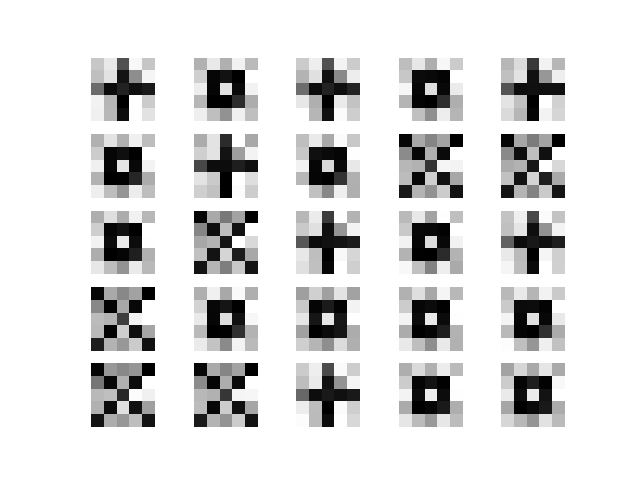

Epoch: 21, d1=0.599, d2=0.623, g=0.811
Epoch: 22, d1=0.737, d2=0.787, g=0.681
Epoch: 23, d1=0.654, d2=0.641, g=0.818
Epoch: 24, d1=0.807, d2=0.862, g=0.597
Epoch: 25, d1=0.898, d2=0.692, g=0.747
Epoch: 26, d1=0.881, d2=0.769, g=0.647
Epoch: 27, d1=0.726, d2=0.632, g=0.843
Epoch: 28, d1=0.779, d2=0.683, g=0.755
Epoch: 29, d1=0.658, d2=0.723, g=0.709
Epoch: 30, d1=0.636, d2=0.746, g=0.675


<IPython.core.display.Javascript object>


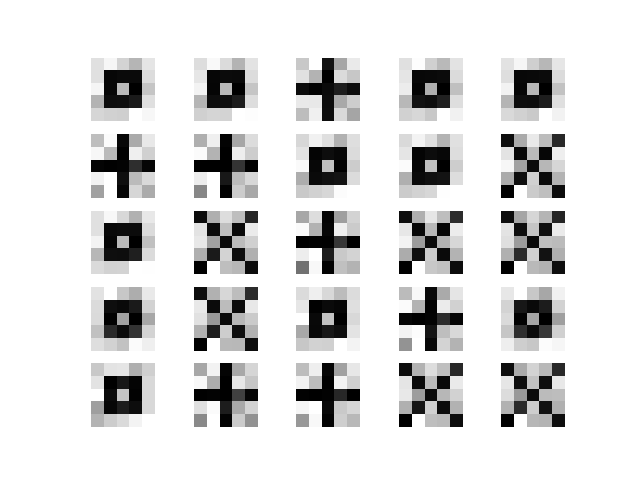

Epoch: 31, d1=0.592, d2=0.689, g=0.747
Epoch: 32, d1=0.725, d2=0.721, g=0.742
Epoch: 33, d1=0.713, d2=0.660, g=0.781
Epoch: 34, d1=0.789, d2=0.778, g=0.639
Epoch: 35, d1=0.632, d2=0.705, g=0.711
Epoch: 36, d1=0.682, d2=0.659, g=0.773
Epoch: 37, d1=0.656, d2=0.672, g=0.756
Epoch: 38, d1=0.769, d2=0.761, g=0.662
Epoch: 39, d1=0.781, d2=0.719, g=0.703
Epoch: 40, d1=0.728, d2=0.641, g=0.781


<IPython.core.display.Javascript object>


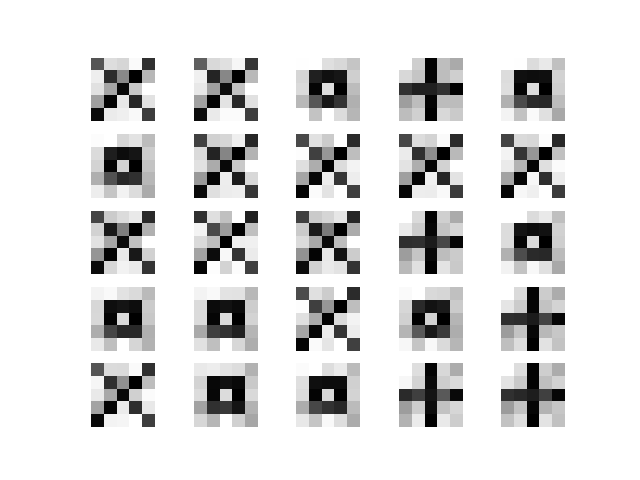

Epoch: 41, d1=0.712, d2=0.642, g=0.778
Epoch: 42, d1=0.687, d2=0.769, g=0.659
Epoch: 43, d1=0.626, d2=0.675, g=0.756
Epoch: 44, d1=0.684, d2=0.589, g=0.857
Epoch: 45, d1=0.620, d2=0.588, g=0.872
Epoch: 46, d1=0.716, d2=0.649, g=0.765
Epoch: 47, d1=0.678, d2=0.693, g=0.722
Epoch: 48, d1=0.697, d2=0.742, g=0.674
Epoch: 49, d1=0.726, d2=0.692, g=0.729
Epoch: 50, d1=0.710, d2=0.707, g=0.718


<IPython.core.display.Javascript object>


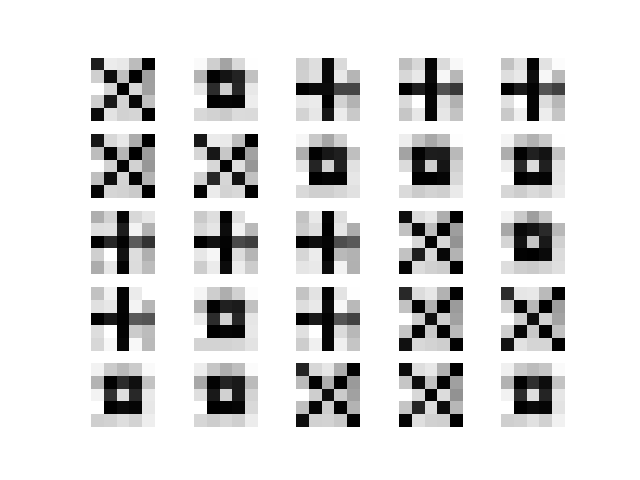

Epoch: 51, d1=0.748, d2=0.632, g=0.787
Epoch: 52, d1=0.671, d2=0.605, g=0.845
Epoch: 53, d1=0.806, d2=0.818, g=0.612
Epoch: 54, d1=0.619, d2=0.622, g=0.813
Epoch: 55, d1=0.731, d2=0.671, g=0.750
Epoch: 56, d1=0.680, d2=0.671, g=0.758
Epoch: 57, d1=0.671, d2=0.696, g=0.733
Epoch: 58, d1=0.791, d2=0.664, g=0.770
Epoch: 59, d1=0.684, d2=0.693, g=0.719
Epoch: 60, d1=0.763, d2=0.701, g=0.716


<IPython.core.display.Javascript object>


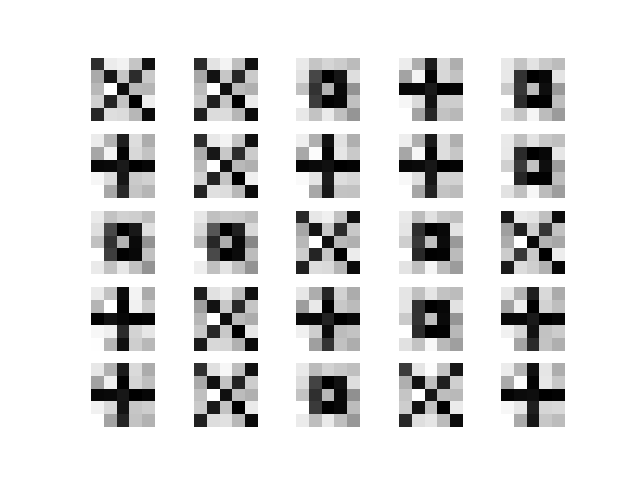

Epoch: 61, d1=0.686, d2=0.719, g=0.713
Epoch: 62, d1=0.702, d2=0.792, g=0.642
Epoch: 63, d1=0.709, d2=0.726, g=0.702
Epoch: 64, d1=0.697, d2=0.742, g=0.669
Epoch: 65, d1=0.733, d2=0.646, g=0.788
Epoch: 66, d1=0.785, d2=0.704, g=0.717
Epoch: 67, d1=0.637, d2=0.725, g=0.708
Epoch: 68, d1=0.668, d2=0.778, g=0.631
Epoch: 69, d1=0.648, d2=0.650, g=0.779
Epoch: 70, d1=0.782, d2=0.748, g=0.687


<IPython.core.display.Javascript object>


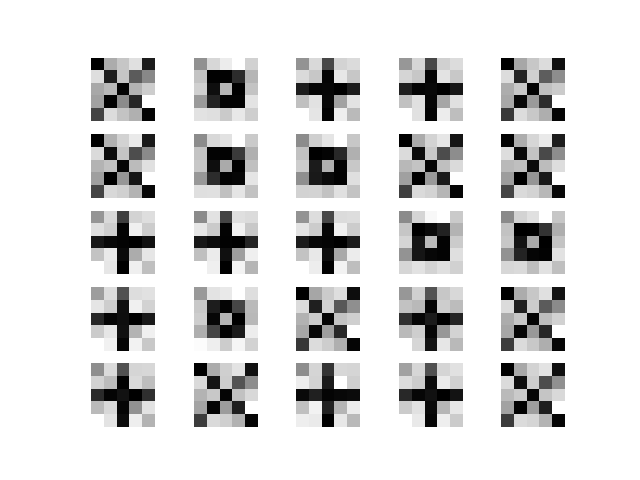

Epoch: 71, d1=0.828, d2=0.701, g=0.739
Epoch: 72, d1=0.686, d2=0.608, g=0.838
Epoch: 73, d1=0.658, d2=0.687, g=0.728
Epoch: 74, d1=0.671, d2=0.642, g=0.804
Epoch: 75, d1=0.683, d2=0.676, g=0.753
Epoch: 76, d1=0.733, d2=0.717, g=0.707
Epoch: 77, d1=0.608, d2=0.620, g=0.802
Epoch: 78, d1=0.712, d2=0.787, g=0.653
Epoch: 79, d1=0.639, d2=0.643, g=0.775
Epoch: 80, d1=0.647, d2=0.748, g=0.699


<IPython.core.display.Javascript object>


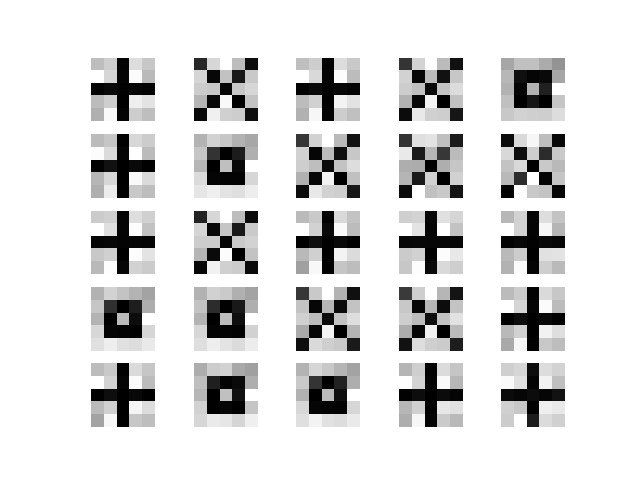

Epoch: 81, d1=0.735, d2=0.730, g=0.745
Epoch: 82, d1=0.787, d2=0.765, g=0.661
Epoch: 83, d1=0.686, d2=0.697, g=0.718
Epoch: 84, d1=0.799, d2=0.813, g=0.614
Epoch: 85, d1=0.659, d2=0.686, g=0.711
Epoch: 86, d1=0.737, d2=0.698, g=0.721
Epoch: 87, d1=0.722, d2=0.632, g=0.793
Epoch: 88, d1=0.783, d2=0.787, g=0.637
Epoch: 89, d1=0.711, d2=0.696, g=0.726
Epoch: 90, d1=0.716, d2=0.707, g=0.722


<IPython.core.display.Javascript object>


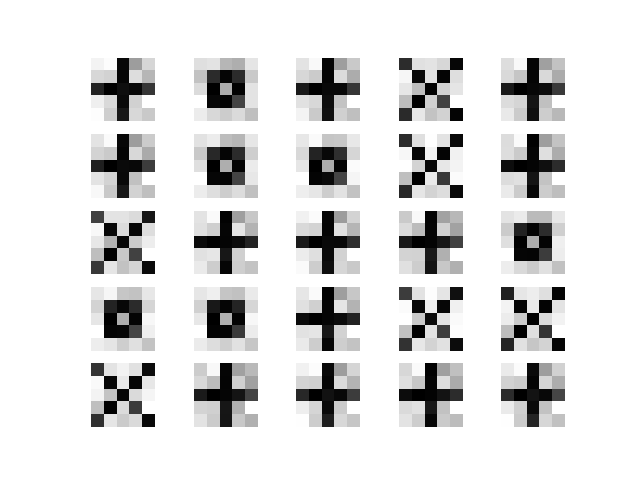

Epoch: 91, d1=0.710, d2=0.731, g=0.681
Epoch: 92, d1=0.591, d2=0.661, g=0.757
Epoch: 93, d1=0.736, d2=0.735, g=0.681
Epoch: 94, d1=0.695, d2=0.717, g=0.700
Epoch: 95, d1=0.758, d2=0.711, g=0.706
Epoch: 96, d1=0.754, d2=0.680, g=0.748
Epoch: 97, d1=0.752, d2=0.751, g=0.673
Epoch: 98, d1=0.668, d2=0.686, g=0.727
Epoch: 99, d1=0.680, d2=0.763, g=0.653
Epoch: 100, d1=0.702, d2=0.743, g=0.679


<IPython.core.display.Javascript object>


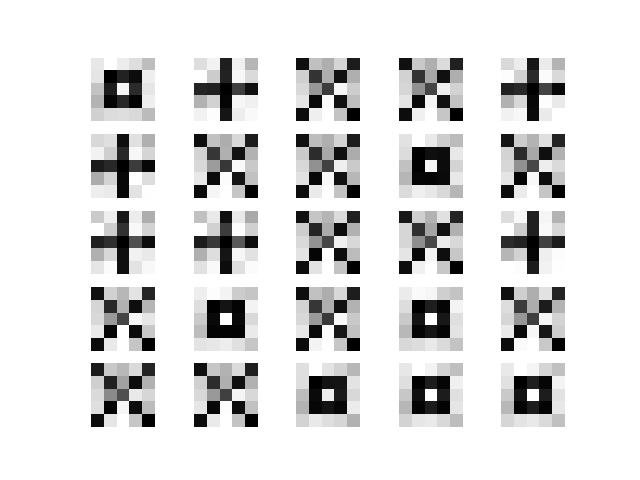

In [33]:
train(g_model, d_model, gan_model)

### Interpolating the results

<IPython.core.display.Javascript object>


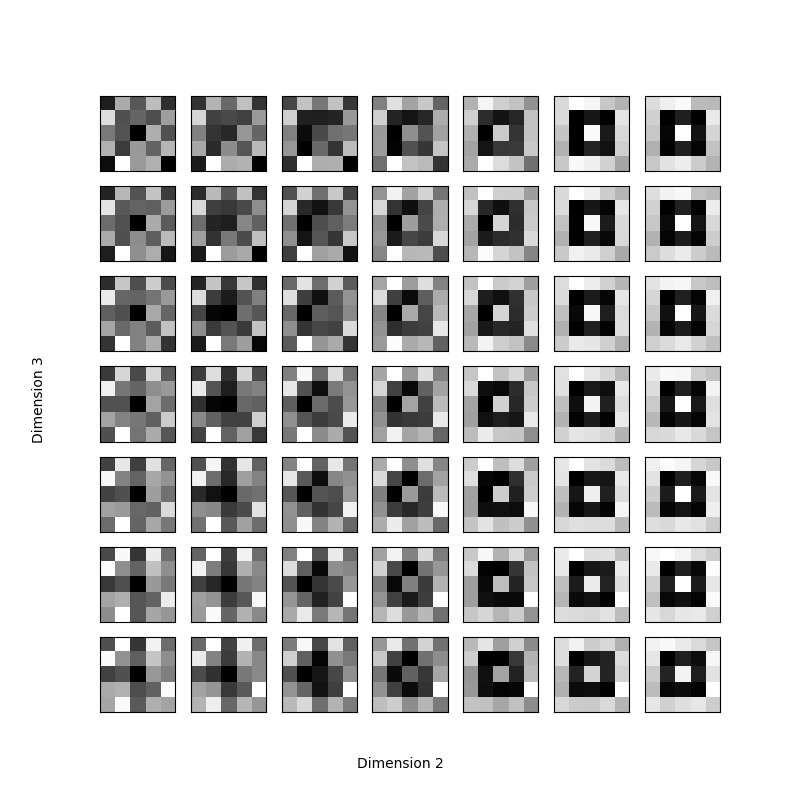

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Dimension 1', max=1.1524460…

In [34]:
fig, axs = plt.subplots(nrows=7, ncols = 7, figsize=(8, 8))
fig.text(0.5, 0.04, 'Dimension 2', ha='center')
fig.text(0.04, 0.5, 'Dimension 3', va='center', rotation='vertical')

grid_x = np.linspace(0.8 * np.min(z[:, 1]), 0.8 * np.max(z[:, 1]), 7)
grid_y = np.linspace(0.8 * np.min(z[:, 2]), 0.8 * np.max(z[:, 2]), 7)[::-1]

def update(dimension1 = 0.0):
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            ax = axs[j][i]
            z_sample = np.array([[dimension1, xi, yi]])
            x_decoded = g_model.predict(z_sample)
            sign = x_decoded[0].reshape(sign_size, sign_size)
            ax.imshow(sign, cmap='gray')
            ax.set_xticks([], [])
            ax.set_yticks([], [])


interact(update, dimension1 = FloatSlider(value=0.0,
                                        min=0.8 * np.min(z[:, 0]),
                                        max=0.8 * np.max(z[:, 0]),
                                        step=(0.8 * np.max(z[:, 0]) - 0.8 * np.min(z[:, 0]))/10, 
                                        description='Dimension 1',
                                        continuous_update=False))

plt.show()